In [2]:
from random import random
import numpy as np

In [3]:
def get_random_points(n):
    return np.random.uniform(-1, 1, [n, 2])

def get_random_line_vector():
    rp = np.random.uniform(-1, 1, (2, 2)) 
    slope = (rp[0, 1] - rp[1, 1]) / (rp[0, 0] - rp[1, 0])
    intercept = rp[0, 1] - rp[0, 0] * slope
    return [intercept, slope, 1]    

def get_labels(pi, vector):
    labels = np.sign(np.dot(pi, vector))
    return labels

def add_intercept(points):
    pi = np.array([[1, x1, x2] for (x1, x2) in points])
    return pi

In [4]:
def get_initial_w():
    w = np.array([0, 0 , 0.001])
    return w

In [5]:
def get_perceptron_predictions(pi, labels, w):
    return np.sign(np.dot(pi, w)) == labels

def update_w(w, mp, label):
    return w + label*mp

In [18]:
from itertools import count

def train_perceptron(pi, labels, w): 
    for num_iterations in count(start=0, step=1):    
        predictions = get_perceptron_predictions(pi, labels, w)

        if predictions.all():
            break

        missclassified_points_indexes = np.where(predictions==False)[0]
        k = np.random.choice(missclassified_points_indexes, 1)[0]
        w = update_w(w, pi[k], labels[k])
#         print(w)
    return w, num_iterations

In [52]:
N_TEST = 10000
points_test = get_random_points(N_TEST) # hack for speed
pi_test = add_intercept(points_test)

def evaluate_perceptron(w, fx_vector):
    labels_test = get_labels(pi_test, fx_vector)
    return get_perceptron_predictions(pi_test, labels_test, w).sum() / N_TEST

In [53]:
def run_perceptron_experiment(n=10, animate=False):
    points = get_random_points(n)
    fx_vector = get_random_line_vector()
    pi = add_intercept(points)
    labels = get_labels(pi, fx_vector)
    w = get_initial_w()

    w, iterations = train_perceptron(pi, labels, w)
    return evaluate_perceptron(w, fx_vector)

In [54]:
RUNS = 10000
N  = 10
perceptron_accuracy = 0

for i in range(RUNS):
    perceptron_accuracy += run_perceptron_experiment(N)

print(perceptron_accuracy/RUNS)

0.88906206


# SVM

In [55]:
from cvxopt import matrix, solvers

In [56]:
>>> Q = 2*matrix([ [2, .5], [.5, 1] ])
>>> p = matrix([1.0, 1.0])
>>> G = matrix([[-1.0,0.0],[0.0,-1.0]])
>>> h = matrix([0.0,0.0])
>>> A = matrix([1.0, 1.0], (1,2))
>>> b = matrix(1.0)
>>> sol=solvers.qp(Q, p, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  3e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  1e-16  5e-08
Optimal solution found.


In [57]:
print(sol['x'])

[ 2.50e-01]
[ 7.50e-01]



In [123]:
def fit_svm(x, y):
    NUM = x.shape[0]
    DIM = x.shape[1]
    # we'll solve the dual
    # obtain the kernel
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = True
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


In [124]:
alphas = fit_svm(points, labels)

     pcost       dcost       gap    pres   dres
 0: -4.2632e+00 -1.0403e+01  3e+01  5e+00  2e+00
 1: -1.1091e+01 -1.5087e+01  9e+00  1e+00  7e-01
 2: -2.3844e+01 -2.8021e+01  9e+00  9e-01  4e-01
 3: -2.6071e+01 -2.6926e+01  2e+00  1e-01  6e-02
 4: -2.5735e+01 -2.5852e+01  1e-01  1e-03  5e-04
 5: -2.5816e+01 -2.5817e+01  1e-03  1e-05  5e-06
 6: -2.5817e+01 -2.5817e+01  1e-05  1e-07  5e-08
 7: -2.5817e+01 -2.5817e+01  1e-07  1e-09  5e-10
Optimal solution found.


In [131]:
# get weights
w = np.sum(alphas * labels[:, None] * points, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = labels[cond] - np.dot(points[cond], w)
bias = b[0]

# normalize
norm = np.linalg.norm(w)
w, bias = w / norm, bias / norm

In [132]:
import matplotlib.pyplot as plt

DIM = 2
COLORS = ['red', 'blue']

def plot_data_with_labels(x, y, ax):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])

In [133]:
def plot_separator(ax, w, b):
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.arange(-1, 2)
    ax.plot(x, x * slope + intercept, 'k-')

In [134]:
def get_plot_points_from_vector(vector):
    x = np.array([-1, 1])
    y = (- vector[1] * x - vector[0]) / vector[2]
    return (x, y)

In [136]:
w

array([-0.84204602,  0.53940568])

In [141]:
bias

-0.24687404945098712

In [138]:
fx_vector

[-0.78475866393421767, -2.1083928656251252, 1]

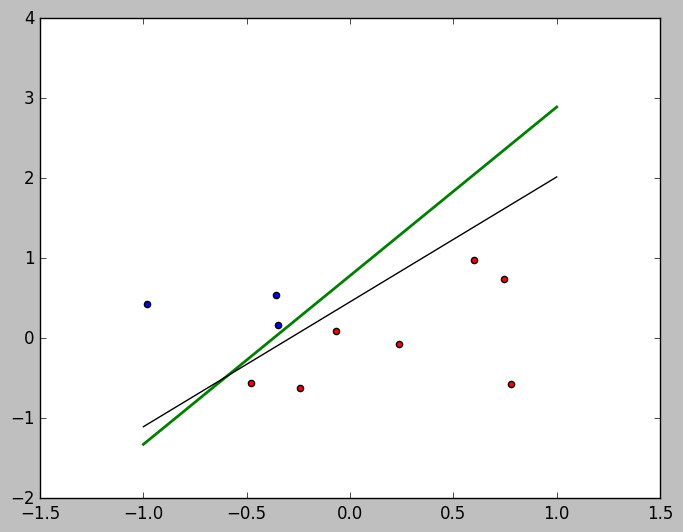

In [142]:
fig, ax = plt.subplots()
# plot_separator(ax, w, 0)
plot_data_with_labels(points, labels, ax)

lx, ly  = get_plot_points_from_vector(fx_vector)
ax.plot(lx, ly, 'g', lw=2)

# show data and w
plot_separator(ax, w, bias)